In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


Bad key "hatch.linewidth" on line 54 in
/home/gpleiss/.dotfiles/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 1001)).cuda()
train_y = Variable(torch.sign(torch.cos(train_x.data * (8 * math.pi)))).cuda()

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable
gpytorch.functions.use_toeplitz = False

In [4]:
class GPClassificationModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPClassificationModel, self).__init__(grid_size=100, grid_bounds=[(0, 1)])
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

model = GPClassificationModel().cuda()
likelihood = BernoulliLikelihood().cuda()

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

def train():
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    optimizer.n_iter = 0
    for i in range(200):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -model.marginal_log_likelihood(likelihood, output, train_y)
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/200 - Loss: %.3f   log_lengthscale: %.3f' % (
            i + 1, loss.data[0],
            model.covar_module.base_kernel_module.log_lengthscale.data.squeeze()[0],
        ))
        optimizer.step()
%time train()

Iter 1/200 - Loss: 475.924   log_lengthscale: 0.000
Iter 2/200 - Loss: 379.204   log_lengthscale: -0.100
Iter 3/200 - Loss: 271.253   log_lengthscale: -0.185
Iter 4/200 - Loss: 225.627   log_lengthscale: -0.259
Iter 5/200 - Loss: 164.497   log_lengthscale: -0.340
Iter 6/200 - Loss: 110.020   log_lengthscale: -0.420
Iter 7/200 - Loss: 85.413   log_lengthscale: -0.492
Iter 8/200 - Loss: 44.792   log_lengthscale: -0.562
Iter 9/200 - Loss: 41.101   log_lengthscale: -0.632
Iter 10/200 - Loss: 24.976   log_lengthscale: -0.710
Iter 11/200 - Loss: 18.955   log_lengthscale: -0.787
Iter 12/200 - Loss: 9.097   log_lengthscale: -0.863
Iter 13/200 - Loss: 7.817   log_lengthscale: -0.936
Iter 14/200 - Loss: 5.278   log_lengthscale: -1.016
Iter 15/200 - Loss: 7.580   log_lengthscale: -1.092
Iter 16/200 - Loss: 9.917   log_lengthscale: -1.168
Iter 17/200 - Loss: 7.281   log_lengthscale: -1.241
Iter 18/200 - Loss: 16.274   log_lengthscale: -1.311
Iter 19/200 - Loss: 12.352   log_lengthscale: -1.379
Ite

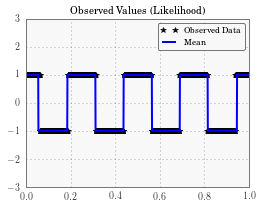

In [6]:
model.eval()
likelihood.eval()

f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
test_x = Variable(torch.linspace(0, 1, 1001)).cuda()
predictions = likelihood(model(test_x))

def ax_plot(ax, rand_var, title):
    ax.plot(train_x.data.cpu().numpy(), train_y.data.cpu().numpy(), 'k*')
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
    ax.plot(test_x.data.cpu().numpy(), pred_labels.data.cpu().numpy(), 'b')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

ax_plot(observed_ax, predictions, 'Observed Values (Likelihood)')